# Data preparation

## Reading the data file

In [1]:
import pandas as pd

headers = ['Date', 'Time', 'Global_active_power', 'Global_reactive_power',
           'Voltage', 'Global_intensity', 'Sub_metering_1', 'Sub_metering_2',
           'Sub_metering_3']

dtypes = {'Date':'str', 'Time':'str', 'Global_active_power':'float',
          'Global_reactive_power': 'float', 'Voltage':'float',
          'Global_intensity':'float', 'Sub_metering_1':'float',
          'Sub_metering_2':'float', 'Sub_metering_3':'float'}

df = pd.read_csv('household_power_consumption.txt', sep=';',
                 dtype=dtypes, na_values=['?'])
df.head()

,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,16/12/2006,17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0
1,16/12/2006,17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0
2,16/12/2006,17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0
3,16/12/2006,17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0
4,16/12/2006,17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0


## Parsing the date and time fields

In [2]:
import numpy as np
from multiprocessing import cpu_count, Pool

def parallel_map(data, func):
    n_cores = cpu_count()
    data_split = np.array_split(data, n_cores)
    pool = Pool(n_cores)
    data = pd.concat(pool.map(func, data_split))
    pool.close()
    pool.join()
    return data

def parse(row):
    row['DateTime'] = pd.to_datetime(row['DateTime'],
                                     format='%d/%m/%Y %H:%M:%S')
    return row

In [3]:
df['DateTime'] = df['Date'] + ' ' + df['Time']
df.dtypes

Date                      object
Time                      object
Global_active_power      float64
Global_reactive_power    float64
Voltage                  float64
Global_intensity         float64
Sub_metering_1           float64
Sub_metering_2           float64
Sub_metering_3           float64
DateTime                  object
dtype: object

Now we can drop the original date and time fields and set the new DateTime field as index. Since the new field is of type datetime64[ns], setting it as index will change the type of the index to DateTimeIndex, which encapsulates the core of pandas support for time series.

In [4]:
df.drop(['Date', 'Time'], axis=1, inplace=True)
df = df[[df.columns[-1]] + list(df.columns[:-1])]
df.set_index('DateTime', inplace=True)
df.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
DateTime,,,,,,,
16/12/2006 17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0
16/12/2006 17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0
16/12/2006 17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0
16/12/2006 17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0
16/12/2006 17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0


## Engineering some features

Since the data represents power consumption, it might make sense to engineer features such as day of week, month of year, and hour of day. These may provide information useful for predicting power consumption.

In [5]:
df.index = pd.to_datetime(df.index)
month_index = df.index.to_period('M')
df['hour'] = df.index.hour
df['day'] = df.index.day
df['month'] = df.index.month
df['day_of_week'] = df.index.dayofweek

The active energy consumed every minute (in watt hour) in the household by electrical equipment not measured in sub-meterings 1, 2 and 3 is given as

In [6]:
df['Rest_active_power'] = df['Global_active_power'] * 1000 / 60 - \
                          df['Sub_metering_1'] - df['Sub_metering_2'] - \
                          df['Sub_metering_3']

In [7]:
number = len(df) - len(df.dropna())
percentage = number * 100 / len(df)


## Missing data

Check if there is any missing data in the dataset.

In [8]:
df[df.isnull()].head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,hour,day,month,day_of_week,Rest_active_power
DateTime,,,,,,,,,,,,
2006-12-16 17:24:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2006-12-16 17:25:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2006-12-16 17:26:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2006-12-16 17:27:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2006-12-16 17:28:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


It seems that much of the missing data is consecutive instances. Therefore, I wouldn't attempt to fill them. Instead, I will leave them as they are for now. They will be dropped later after transforming the data to a supervised setting.

# Visualization of aggregated data

## Aesthetics

In [9]:
import matplotlib.pylab as plt
import matplotlib.dates as mdates
my_fmt = mdates.DateFormatter('%a %d/%m %H:%M')

# Tableau colors
tableau20 = [(31, 119, 180), (174, 199, 232), (255, 127, 14), (255, 187, 120),
             (44, 160, 44), (152, 223, 138), (214, 39, 40), (255, 152, 150),
             (148, 103, 189), (197, 176, 213), (140, 86, 75), (196, 156, 148),
             (227, 119, 194), (247, 182, 210), (127, 127, 127), (199, 199, 199),
             (188, 189, 34), (219, 219, 141), (23, 190, 207), (158, 218, 229)]

# Scale the RGB values to the [0, 1] range, which is the format matplotlib accepts.    
for i in range(len(tableau20)):    
    r, g, b = tableau20[i]
    tableau20[i] = (r / 255., g / 255., b / 255.)

## Global power consumption over the whole timespan

Average global active power over resampled data yearly, quarterly, monthly, and daily.

C:\Users\hp\Anaconda2\lib\site-packages\pandas\plotting\_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


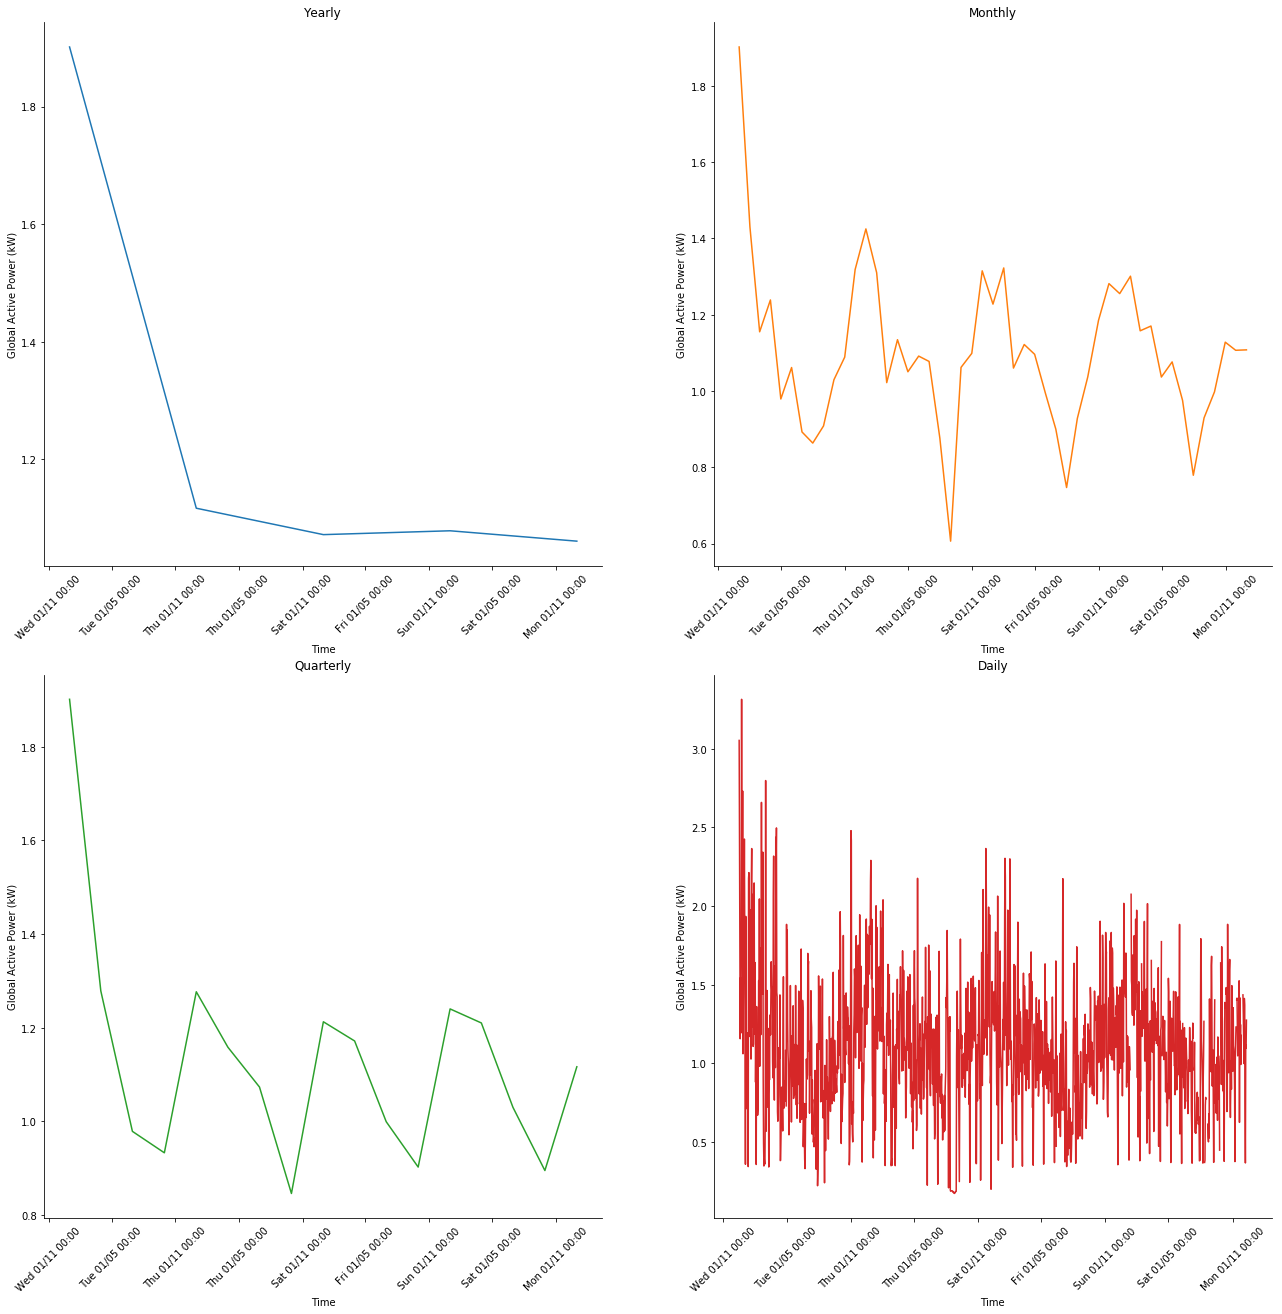

In [10]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(22, 22))

frequencies = ['1Y', '1M', '1Q', '1D']

dic = {'1Y':'Yearly', '1M':'Monthly', '1Q':'Quarterly', '1D':'Daily'}

i = 0
for row in ax:
    for col in row:
        for tick in col.get_xticklabels():
            tick.set_rotation(45)
        col.plot(df[['Global_active_power']].resample(frequencies[i]).mean(),
                 color=tableau20[i * 2])
        col.set_xlabel('Time')
        col.set_ylabel('Global Active Power (kW)')
        col.set_title(dic[frequencies[i]])
        col.xaxis.set_major_formatter(my_fmt)
        
        # Aesthetics
        col.spines["top"].set_visible(False)    
        col.spines["right"].set_visible(False)    
        i += 1

Here, we can clearly see a quarterly seasonal trend in the data. Electricity consumption peaks in the winter and goes down in the summer.

## What happens on Sundays

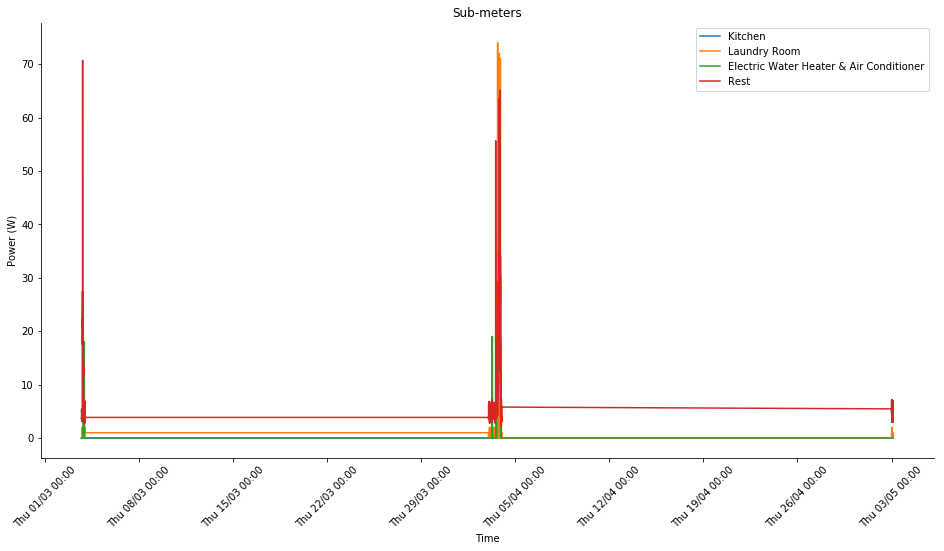

In [11]:
fig = plt.figure(figsize=(16, 8))
ax = plt.axes()

# How many minutes in a week?
week = 60 * 24 * 7

columns = ['Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3', 'Rest_active_power']
names = ['Kitchen', 'Laundry Room', 'Electric Water Heater & Air Conditioner', 'Rest']

d = {key:value for (key, value) in zip(columns, names)}

for i in range(4):
    plt.plot(df[[columns[i]]][week * 11:week * 11 + 2000], color=tableau20[i * 2])

ax.set_xlabel('Time')
ax.set_ylabel('Power (W)')
ax.set_title('Sub-meters')
ax.xaxis.set_major_formatter(my_fmt)

# Aesthetics
ax.spines["top"].set_visible(False)    
ax.spines["right"].set_visible(False)

plt.legend(list(map(lambda x:d[x], columns)))

for tick in ax.get_xticklabels():
    tick.set_rotation(45)

Things get crazy Sunday evening!

# Data preparation for supervised learning

One way to create a model that forecasts power consumption is by formulating the forecasting problem as a supervised learning problem. I formulate the problem as follows: predict global active power at time $t + h$ given all the variables at times $t, t-1, ..., t-w$, where $h$ is the prediction horizon and $w$ is the window size. Here's a function that takes as input a time series dataframe, a window size, a horizon, a set of variables to be lagged and a set of variables to be forecasted and outputs the dataframe transformed and ready for supervised learing.

In [12]:
from pandas import DataFrame
from pandas import concat
 
def series_to_supervised(data, window_size=1, horizon=1, inputs='all', targets='all'):
    """
    Frame a time series as a supervised learning dataset.
    
    Arguments:
        data: A pandas DataFrame containing the time series
        (the index must be a DateTimeIndex).
        window_size: Number of lagged observations as input.
        horizon: Number of steps to forecast ahead.
        inputs: A list of the columns of the dataframe to be lagged.
        targets: A list of the columns of the dataframe to be forecasted.
    
    Returns:
        Pandas DataFrame of series framed for supervised learning.
    """
    
    if targets == 'all':
        targets = data.columns
    
    if inputs == 'all':
        inputs = data.columns

    
    result = DataFrame(index=df.index)
    names = []
    
    # input sequence (t-w, ..., t-1)
    for i in range(window_size, 0, -1):
        result = pd.concat([result, data[inputs].shift(i)], axis=1)
        names += [('{data[inputs].columns[j]}(t-{i})') for j in range(len(inputs))]
    
    # the input not shifted (t)
    result = pd.concat([result, data.copy()], axis=1)
    names += [('{column}(t)') for column in data.columns]
    
    # forecast (t+h)
    for i in [horizon]:
        result = pd.concat([result, data[targets].shift(-i)], axis=1)
        names += [('{data[targets].columns[j]}(t+{i})') for j in range(len(targets))]
    
    # put it all together
    result.columns = names

    # drop rows with NaN values
    result.dropna(inplace=True)
    return result

Let's check if this works as intended

In [13]:
inputs = ['Global_active_power', 'Global_reactive_power', 'Voltage',
          'Global_intensity', 'Sub_metering_1', 'Sub_metering_2',
          'Sub_metering_3', 'Rest_active_power']

targets = ['Global_active_power']

df_supervised = series_to_supervised(df, window_size=5, horizon=1, inputs=inputs, targets=targets)
df_supervised.head()

,{data[inputs].columns[j]}(t-{i}),{data[inputs].columns[j]}(t-{i}),{data[inputs].columns[j]}(t-{i}),{data[inputs].columns[j]}(t-{i}),{data[inputs].columns[j]}(t-{i}),{data[inputs].columns[j]}(t-{i}),{data[inputs].columns[j]}(t-{i}),{data[inputs].columns[j]}(t-{i}),{data[inputs].columns[j]}(t-{i}),{data[inputs].columns[j]}(t-{i}),...,{column}(t),{column}(t),{column}(t),{column}(t),{column}(t),{column}(t),{column}(t),{column}(t),{column}(t),{data[targets].columns[j]}(t+{i})
DateTime,,,,,,,,,,,,,,,,,,,,,
2006-12-16 17:29:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0,52.266667,5.360,0.436,...,15.0,0.0,2.0,17.0,17,16,12,5,39.666667,3.702
2006-12-16 17:30:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0,72.333333,5.374,0.498,...,15.8,0.0,1.0,17.0,17,16,12,5,43.700000,3.700
2006-12-16 17:31:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0,70.566667,5.388,0.502,...,15.8,0.0,1.0,17.0,17,16,12,5,43.666667,3.668
2006-12-16 17:32:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0,71.800000,3.666,0.528,...,15.8,0.0,1.0,17.0,17,16,12,5,43.133333,3.662
2006-12-16 17:33:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0,43.100000,3.520,0.522,...,15.8,0.0,2.0,16.0,17,16,12,5,43.033333,4.448


Perfect. We can now start applying supervised machine learning algorithms to this dataset. There are multiple variables that could be interesting to study like how changing the windows size for a fixed forecasting horizon affects forecast quality, how forecast quality deteriorates as the forecasting horizon grows, and whether resampling and attempting to forecast on larger time steps works.

One can devise a large scale experiment where multiple supervised learning datasets are generated with different window sizes, horizons and step sizes. A supervised machine learning algorithm would be applied on each of them and results could be stored and later nicely visualized.

For now I'm going to stick with a window size of 5, a horizon of 1 and the default time step of 1 minute. I'll save the dataframe to a file, so I can restart the kernel to free some memory.

In [14]:
df_supervised.to_csv('supervised_w10_h1.csv', index=True)

# Supervised machine learning

In [15]:
import pandas as pd

df_supervised = pd.read_csv('supervised_w10_h1.csv', parse_dates=['DateTime'])
df_supervised.set_index('DateTime', inplace=True)
df_supervised.head()

,{data[inputs].columns[j]}(t-{i}),{data[inputs].columns[j]}(t-{i}).1,{data[inputs].columns[j]}(t-{i}).2,{data[inputs].columns[j]}(t-{i}).3,{data[inputs].columns[j]}(t-{i}).4,{data[inputs].columns[j]}(t-{i}).5,{data[inputs].columns[j]}(t-{i}).6,{data[inputs].columns[j]}(t-{i}).7,{data[inputs].columns[j]}(t-{i}).8,{data[inputs].columns[j]}(t-{i}).9,...,{column}(t).3,{column}(t).4,{column}(t).5,{column}(t).6,{column}(t).7,{column}(t).8,{column}(t).9,{column}(t).10,{column}(t).11,{data[targets].columns[j]}(t+{i})
DateTime,,,,,,,,,,,,,,,,,,,,,
2006-12-16 17:29:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0,52.266667,5.360,0.436,...,15.0,0.0,2.0,17.0,17,16,12,5,39.666667,3.702
2006-12-16 17:30:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0,72.333333,5.374,0.498,...,15.8,0.0,1.0,17.0,17,16,12,5,43.700000,3.700
2006-12-16 17:31:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0,70.566667,5.388,0.502,...,15.8,0.0,1.0,17.0,17,16,12,5,43.666667,3.668
2006-12-16 17:32:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0,71.800000,3.666,0.528,...,15.8,0.0,1.0,17.0,17,16,12,5,43.133333,3.662
2006-12-16 17:33:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0,43.100000,3.520,0.522,...,15.8,0.0,2.0,16.0,17,16,12,5,43.033333,4.448


## Splitting the data

Data is split into training, validation and test sets without shuffling. I am not certain about whether shuffling would be wrong in this case, but I don't shuffle just to be safe.

In [16]:
percentages = (0.6, 0.2, 0.2)

split_points = (int(len(df_supervised) * percentages[0]),
                int(len(df_supervised) * (percentages[0] + percentages[1])))

train, validate, test = df_supervised.iloc[:split_points[0]].copy(), \
                        df_supervised.iloc[split_points[0]:split_points[1]].copy(), \
                        df_supervised.iloc[split_points[1]:].copy()

In [23]:
X_train = train.values[:, :-1]
y_train = train.values[:, -1]

X_validate = validate.values[:, :-1]
y_validate = validate.values[:, -1]

X_test = test.values[:, :-1]
y_test = test.values[:, -1]

## Baseline model

Naive baseline model: power consumption at time $t + 1$ is the same as power consumption at time $t$:

In [38]:
from sklearn.metrics import mean_squared_error

mean_squared_error(validate['{data[targets].columns[j]}(t+{i})'], validate['{data[inputs].columns[j]}(t-{i}).8'])

0.27423846817856806

## Linear regression

Not-so-naive-but-still-naive model:

In [25]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(X_train, y_train)
predictions = model.predict(X_validate)

In [26]:
from sklearn.metrics import mean_squared_error

mean_squared_error(predictions, y_validate)

0.05588631569025376

## Multilayer perceptron

A better model

In [27]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_validate = scaler.transform(X_validate)
X_test = scaler.transform(X_test)

In [28]:
from keras.models import Sequential
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras.layers import Input, Dense, Dropout, LSTM, Reshape, Flatten

model = Sequential()
model.add(Dense(100, activation='relu', input_shape=(X_train.shape[1], )))
model.add(Dropout(0.2))
model.add(Dense(1))

Using TensorFlow backend.


In [30]:
model.compile(loss='mean_squared_error',
              optimizer=Adam(lr=0.001))

history = model.fit(X_train, y_train,
                    batch_size=1024,
                    epochs=1,
                    verbose=1,
                    validation_data=(X_validate, y_validate),
                    callbacks=[EarlyStopping(patience=1)])

Train on 1229311 samples, validate on 409771 samples
Epoch 1/1
1229311/1229311 [==============================] - 13s 11us/step - loss: 0.0814 - val_loss: 0.0524


In [31]:
predictions = model.predict(X_validate)

In [32]:
mean_squared_error(predictions, y_validate)

0.05237441943557072

This is significantly better than the baseline models.

## Visualize forecasts

In [33]:
predictions = model.predict(X_test)

In [39]:
df_to_plot = test[['{data[targets].columns[j]}(t+{i})']].copy()
df_to_plot['Global_active_power(t+1)_predicted'] = predictions

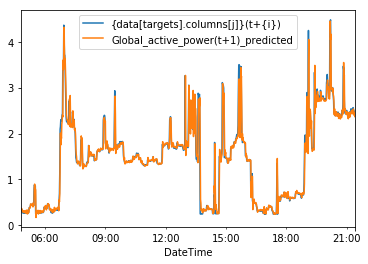

In [40]:
import matplotlib.pylab as plt

df_to_plot[:1000].plot()
plt.show()